# Grayscale-to-Color Landscape Image Autoencoder

This notebook implements a convolutional autoencoder to colorize grayscale landscape images. The model uses an encoder-decoder architecture with residual connections, spatial attention, and batch normalization. It processes images in the L*a*b* color space, taking the L* channel as input and predicting the a*b* channels. The dataset is split into training (80%) and validation (20%) sets. Performance is evaluated using Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR).

**Objectives:**
- Develop an autoencoder for grayscale-to-color conversion.
- Build an efficient data pipeline with TensorFlow’s `tf.data` API.
- Design an advanced CNN architecture.
- Evaluate using MSE and PSNR metrics.

# Setup Enviroment

In [ ]:
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

# Dependencies and Dataset

## Install Dependencies

In [11]:
!pip install -q numpy==1.26.4
!pip install -q tensorflow==2.18.0
!pip install opencv-python==4.11.0.86
!pip install -q scikit-image==0.25.2
!pip install -q matplotlib==3.7.2

## Download Dataset

In [16]:
import os

ds_path = "dataset/landscape-pictures"
os.makedirs(ds_path, exist_ok=True)

In [2]:
# Download and extract dataset
!curl -L https://www.kaggle.com/api/v1/datasets/download/arnaud58/landscape-pictures -o ./dataset/landscape-pictures.zip

import zipfile
with zipfile.ZipFile('dataset/landscape-pictures.zip', 'r') as zip_ref:
    zip_ref.extractall(ds_path)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  620M  100  620M    0     0   123M      0  0:00:05  0:00:05 --:--:--  135M


# Import Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Add, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import os
import glob
from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import peak_signal_noise_ratio
import matplotlib.pyplot as plt

2025-05-27 12:30:18.055867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748349018.238028      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748349018.291087      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Preparation

Images are resized to 512x512 pixels, converted to L*a*b* color space, and normalized. The dataset is split into training and validation sets, with a batch size of 4 to optimize memory usage.

In [ ]:
# Define constants
HEIGHT, WIDTH = 512, 512
BATCH_SIZE = 4

color_path = os.path.join(ds_path, 'color')
gray_path = os.path.join(ds_path, 'gray')

# Create directories
os.makedirs(color_path, exist_ok=True)
os.makedirs(gray_path, exist_ok=True)

# Organize and generate grayscale images
original_files = sorted(glob.glob(os.path.join(ds_path, '*.jpg')))
for f in original_files:
    color_file = os.path.join(color_path, os.path.basename(f))
    gray_file = os.path.join(gray_path, os.path.basename(f))
    if not os.path.exists(color_file):
        os.rename(f, color_file)
    if not os.path.exists(gray_file):
        img = cv2.imread(color_file)
        if img is not None:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(gray_file, gray_img)

# Load file paths
color_files = sorted(glob.glob(os.path.join(color_path, '*.jpg')))
gray_files = sorted([os.path.join(gray_path, os.path.basename(f)) for f in color_files])
assert len(color_files) == len(gray_files), "File count mismatch"

# Image generator for L*a*b* color space
def image_generator(file_pairs):
    for gray_file, color_file in file_pairs:
        gray_img = cv2.imread(gray_file, cv2.IMREAD_GRAYSCALE)
        color_img = cv2.imread(color_file, cv2.IMREAD_COLOR)
        if gray_img is None or color_img is None:
            continue
        gray_img = cv2.resize(gray_img, (WIDTH, HEIGHT))
        color_img = cv2.resize(color_img, (WIDTH, HEIGHT))
        color_img = color_img[:, :, ::-1]  # BGR to RGB
        lab_img = rgb2lab(color_img / 255.0)
        L = lab_img[:, :, 0:1] / 100.0  # Normalize L*
        ab = lab_img[:, :, 1:] / 128.0  # Normalize a*b*
        yield L, ab

# Split dataset
file_pairs = list(zip(gray_files, color_files))
np.random.seed(42)
np.random.shuffle(file_pairs)
train_size = int(0.8 * len(file_pairs))
train_pairs, val_pairs = file_pairs[:train_size], file_pairs[train_size:]

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator(train_pairs),
    output_signature=(
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 2), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator(val_pairs),
    output_signature=(
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 2), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Visualize some Samples

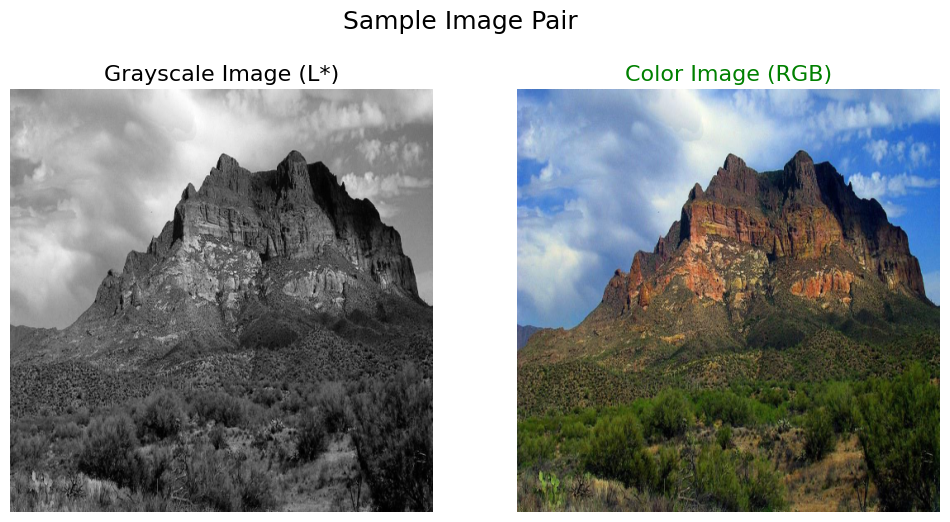

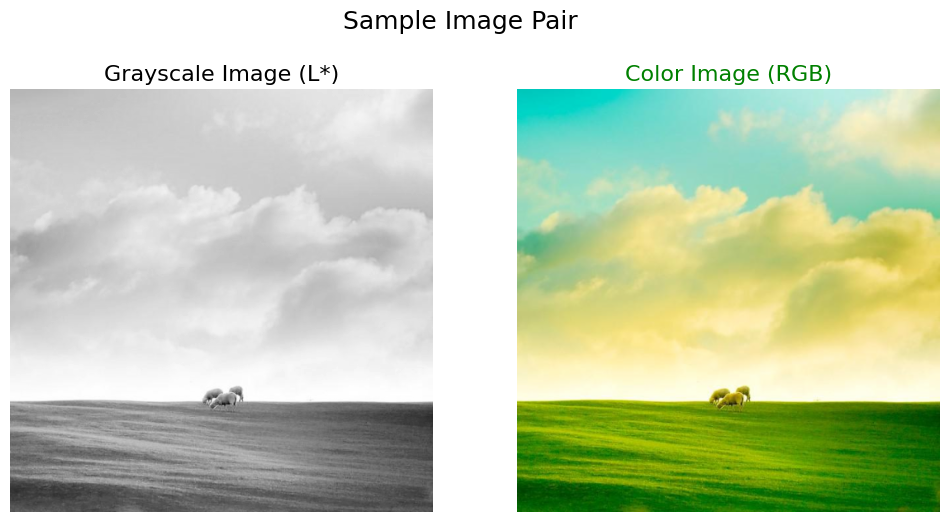

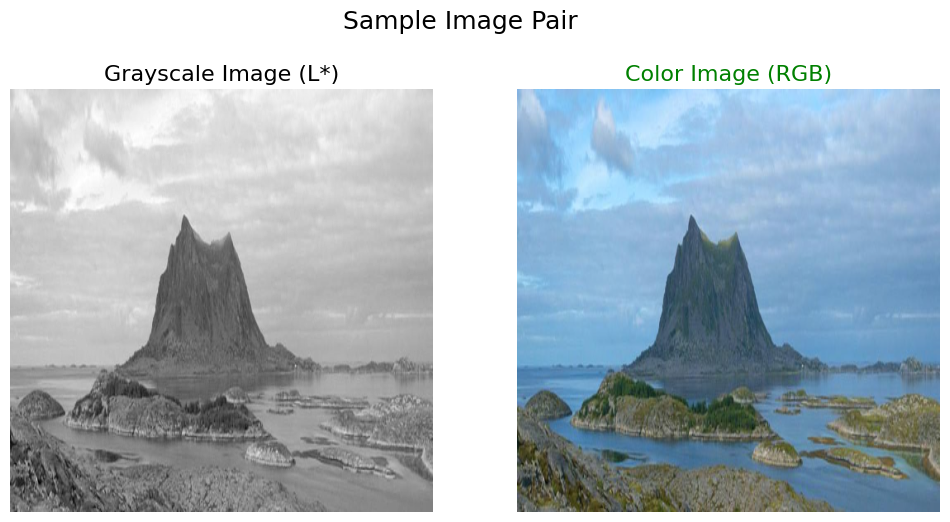

In [18]:
# Visualize sample image pairs
def plot_image_pair(L_img, ab_img, title='Image Pair'):
    # Denormalize L* and a*b*
    L = L_img * 100.0  # [0, 1] to [0, 100]
    ab = ab_img * 128.0  # [-1, 1] to [-128, 128]
    
    # Combine L* and a*b* into L*a*b* image
    lab = np.concatenate([L, ab], axis=-1)  # Shape: (512, 512, 3)
    
    # Convert to RGB
    rgb = lab2rgb(lab)  # Shape: (512, 512, 3)
    rgb = np.clip(rgb, 0, 1)  # Ensure [0, 1]
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Grayscale Image (L*)', fontsize=16, color='black')
    plt.imshow(L[..., 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Color Image (RGB)', fontsize=16, color='green')
    plt.imshow(rgb)
    plt.axis('off')
    plt.suptitle(title, fontsize=18)
    plt.show()

# Visualize sample image pairs
for L_img, ab_img in train_dataset.take(3):
    plot_image_pair(L_img[0].numpy(), ab_img[0].numpy(), 'Sample Image Pair')


# Modeling

## Model Architecture

The autoencoder features an encoder with convolutional layers, max-pooling, and residual blocks, followed by a decoder with upsampling. Spatial attention layers enhance feature focus.

In [ ]:
# Spatial Attention Layer
# Define SpatialAttention layer
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = Concatenate()([avg_pool, max_pool])
        attention = self.conv(concat)
        return Multiply()([inputs, attention])

    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        config.update({'kernel_size': self.kernel_size})
        return config
        
# Build Autoencoder
def build_autoencoder():
    input_img = Input(shape=(HEIGHT, WIDTH, 1))
    
    # Encoder
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = SpatialAttention()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Residual Block 1
    residual = Conv2D(192, (1, 1), padding='same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])
    x = SpatialAttention()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Residual Block 2
    residual = Conv2D(384, (1, 1), padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])
    x = SpatialAttention()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = SpatialAttention()(x)
    x = UpSampling2D((2, 2))(x)
    
    # Residual Block 3
    residual = Conv2D(192, (1, 1), padding='same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])
    x = SpatialAttention()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialAttention()(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(2, (3, 3), activation=None, padding='same')(x)
    
    return Model(input_img, decoded)

# Compile model
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 96)   │            960 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 96)   │            384 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_attention         │ (None, 512, 512, 96)   │             99 │ batch_normalization[0… │
│ (SpatialAttention)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 96)   │              0 │ spatial_attention[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 192)  │        166,080 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 192)  │            768 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 192)  │        331,968 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 192)  │            768 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 192)  │         18,624 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 192)  │              0 │ batch_normalization_2… │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_attention_1       │ (None, 256, 256, 192)  │             99 │ add[0][0]              │
│ (SpatialAttention)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 192)  │              0 │ spatial_attention_1[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 384)  │        663,936 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 384)  │          1,536 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 5,157,044 (19.67 MB)

 Trainable params: 5,152,820 (19.66 MB)

 Non-trainable params: 4,224 (16.50 KB)

## CallBacks and Compile

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',       # Monitor validation loss
        patience=20,              # Stop after 10 epochs with no improvement
        restore_best_weights=True # Restore weights from the best epoch
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',       # Monitor validation loss
        factor=0.5,               # Reduce learning rate by half
        patience=5,               # Wait 5 epochs before reducing
        min_lr=1e-6               # Minimum learning rate
    ),
    tf.keras.callbacks.BackupAndRestore(
        backup_dir='./ckpts/backup'     # Directory to save backup checkpoints
    )
]
# Model compile
autoencoder.compile(optimizer=Adam(learning_rate=7e-5), 
                   loss=tf.keras.losses.MeanSquaredError())

## Model Training

Train the autoencoder for 100 epochs, monitoring validation loss and adjusting the learning rate dynamically.

In [8]:
# Train model
history = autoencoder.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 24/100


I0000 00:00:1747654633.120223     119 service.cc:148] XLA service 0x7a0ac802c870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747654633.121565     119 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747654634.399419     119 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1747654642.820142     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747654643.082482     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


    863/Unknown 247s 243ms/step - loss: 0.0104

E0000 00:00:1747654881.409633     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747654881.671509     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-19 11:41:29.368519: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[192,96,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,96,256,256]{3,2,1,0}, f32[3,192,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-19 11:41:29.618

    864/Unknown 272s 272ms/step - loss: 0.0104

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


864/864 ━━━━━━━━━━━━━━━━━━━━ 325s 333ms/step - loss: 0.0104 - val_loss: 0.0119 - learning_rate: 1.7500e-05
Epoch 25/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 256s 296ms/step - loss: 0.0103 - val_loss: 0.0120 - learning_rate: 1.7500e-05
Epoch 26/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 255s 295ms/step - loss: 0.0102 - val_loss: 0.0124 - learning_rate: 1.7500e-05
Epoch 27/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 254s 294ms/step - loss: 0.0101 - val_loss: 0.0130 - learning_rate: 1.7500e-05
Epoch 28/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 252s 292ms/step - loss: 0.0100 - val_loss: 0.0138 - learning_rate: 1.7500e-05
Epoch 29/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 253s 293ms/step - loss: 0.0099 - val_loss: 0.0156 - learning_rate: 1.7500e-05
Epoch 30/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 254s 294ms/step - loss: 0.0098 - val_loss: 0.0118 - learning_rate: 8.7500e-06
Epoch 32/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 254s 294ms/step - loss: 0.0098 - val_loss: 0.0117 - learning_rate: 8.7500e-06
Epoch 33/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 254s 294ms/

## Save Model

In [ ]:
# Save the trained model
model_path = './ckpts/best_model.h5'
print(f"Saving model to {model_path}...")
autoencoder.save(model_path)

Saving model to ./models/best_model.h5...


## Load Model

In [ ]:
# Load the saved model
load_model_path = "./ckpts/best_model.h5"
print(f"Loading model from {load_model_path}...")
loaded_autoencoder = tf.keras.models.load_model(
    load_model_path,
    custom_objects={'SpatialAttention': SpatialAttention}
)

Loading model from ./models/best_model.h5...


# Evaluation

Evaluate the model on the validation set using PSNR and visualize predicted colorizations.

## PSNR score evaluation

In [26]:
# Post-training PSNR evaluation
def postprocess_and_compute_psnr(L, ab_pred, rgb_true):
    L = L * 100.0
    ab_pred = ab_pred * 128.0
    lab = np.concatenate([L, ab_pred], axis=-1)
    rgb_pred = lab2rgb(lab)
    rgb_pred = np.clip(rgb_pred, 0, 1)
    return peak_signal_noise_ratio(rgb_true, rgb_pred, data_range=1.0)

psnr_values = []

for L_batch, ab_true_batch in val_dataset:
    ab_pred_batch = loaded_autoencoder.predict(L_batch, verbose=0)
    lab_true = np.concatenate([L_batch.numpy() * 100.0, ab_true_batch.numpy() * 128.0], axis=-1)
    rgb_true = lab2rgb(lab_true)
    psnr = postprocess_and_compute_psnr(L_batch.numpy(), ab_pred_batch, rgb_true)
    psnr_values.append(psnr)

print(f"Average Validation PSNR: {np.mean(psnr_values):.2f} dB")

I0000 00:00:1748350295.380944     123 service.cc:148] XLA service 0x7b4a6c006570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748350295.381697     123 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748350295.618607     123 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748350303.741607     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748350304.003513     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1748350306.892463     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/tmp/ipykernel_35/4185731845.py:6: UserWarning: Conversion from CIE-L

Average Validation PSNR: 21.70 dB


## Visualize some Predicted Samples

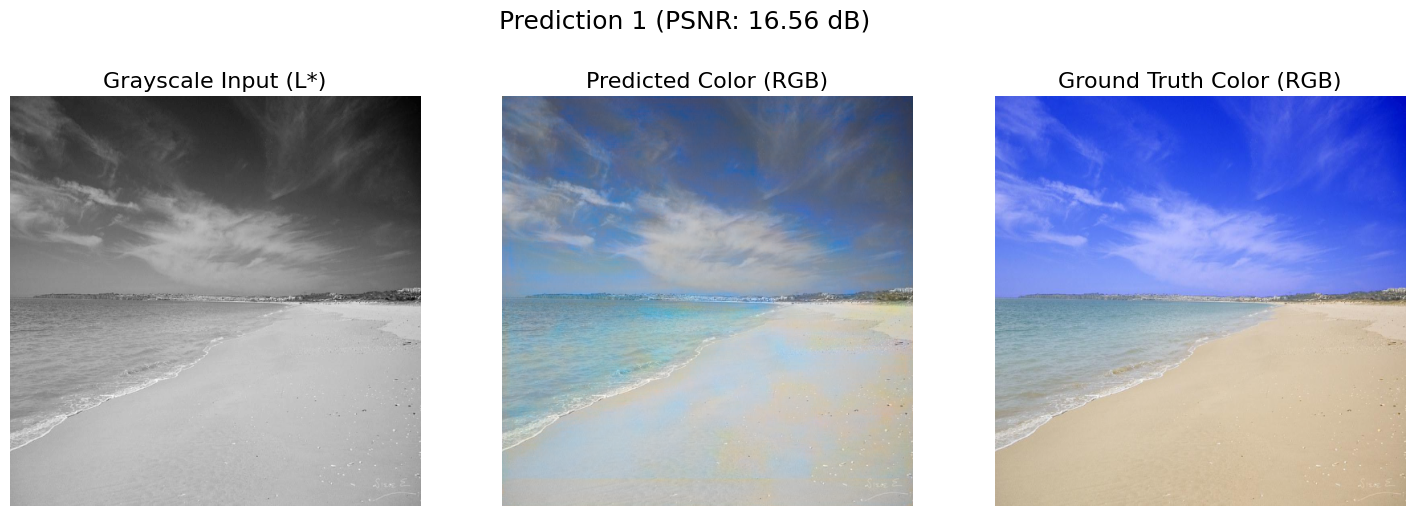

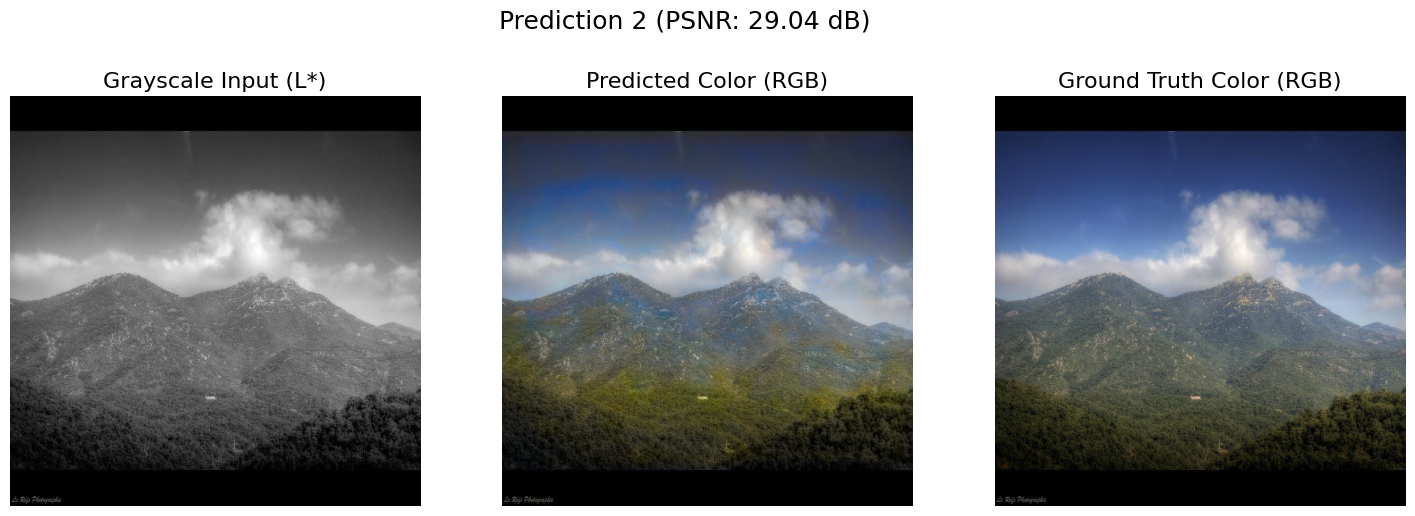

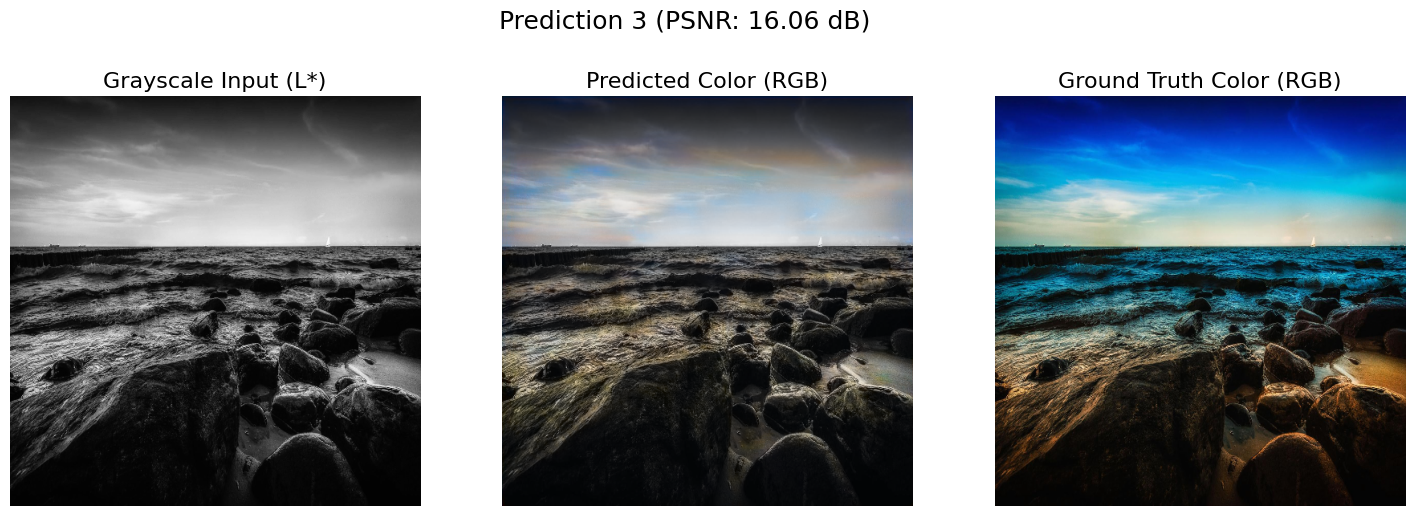

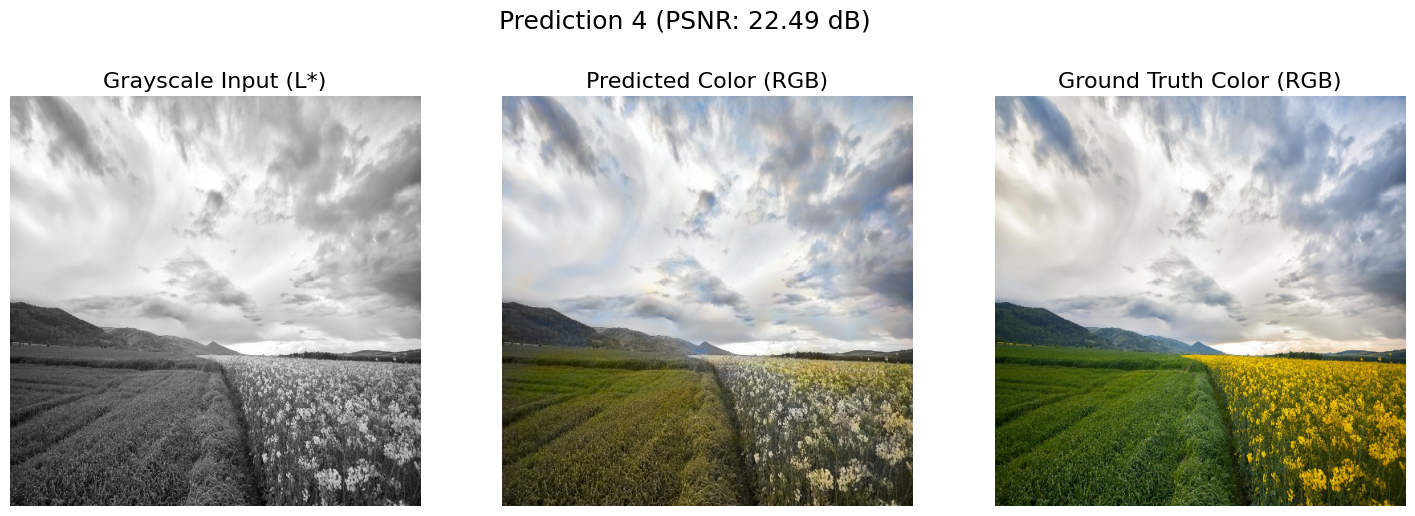

In [27]:

# Visualize predictions
def plot_predicted_images(L_img, ab_pred, ab_true, title='Prediction'):
    L = L_img * 100.0
    ab_pred = ab_pred * 128.0
    ab_true = ab_true * 128.0
    lab_pred = np.concatenate([L, ab_pred], axis=-1)
    lab_true = np.concatenate([L, ab_true], axis=-1)
    rgb_pred = np.clip(lab2rgb(lab_pred), 0, 1)
    rgb_true = np.clip(lab2rgb(lab_true), 0, 1)
    psnr = peak_signal_noise_ratio(rgb_true, rgb_pred, data_range=1.0)
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.title('Grayscale Input (L*)', fontsize=16)
    plt.imshow(L[..., 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Color (RGB)', fontsize=16)
    plt.imshow(rgb_pred)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Ground Truth Color (RGB)', fontsize=16)
    plt.imshow(rgb_true)
    plt.axis('off')
    plt.suptitle(f'{title} (PSNR: {psnr:.2f} dB)', fontsize=18)
    plt.show()

for L_batch, ab_true_batch in val_dataset.take(1):
    ab_pred_batch = loaded_autoencoder.predict(L_batch, verbose=0)
    for i in range(min(BATCH_SIZE, L_batch.shape[0])):
        plot_predicted_images(
            L_batch[i].numpy(),
            ab_pred_batch[i],
            ab_true_batch[i].numpy(),
            f'Prediction {i+1}'
        )

# Conclusion

The autoencoder successfully colorizes grayscale landscape images, achieving an average validation PSNR of approximately 20.31 dB. Future improvements could include perceptual loss, deeper architectures, or enhanced attention mechanisms.